In [42]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
import yaml
import optuna
import json
import datetime
import logging
import sys
import os

from datetime import datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation

config_path = r'../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

model_path = config['train']['model_path']
params_path = config['train']['params_path']
backend_path = config['train']["backend_path"]
pred_days_forecast = config['train']['pred_days_forecast']
metrics_path = config['train']['metrics_path']
sys.path.append(backend_path)
from get_metrics import get_metrics

In [43]:
# Чтение DataFrame df в файл data/df.csv
df_path = config['preprocessing']['df_path']
df = pd.read_csv(df_path)

# Чтение DataFrame df_train в файл data/df_train.csv
train_path = config['preprocessing']['train_path']
df_train = pd.read_csv(train_path)

# Чтение DataFrame df_test в файл data/df_test.csv
test_path = config['preprocessing']['test_path']
df_test = pd.read_csv(test_path)

In [44]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

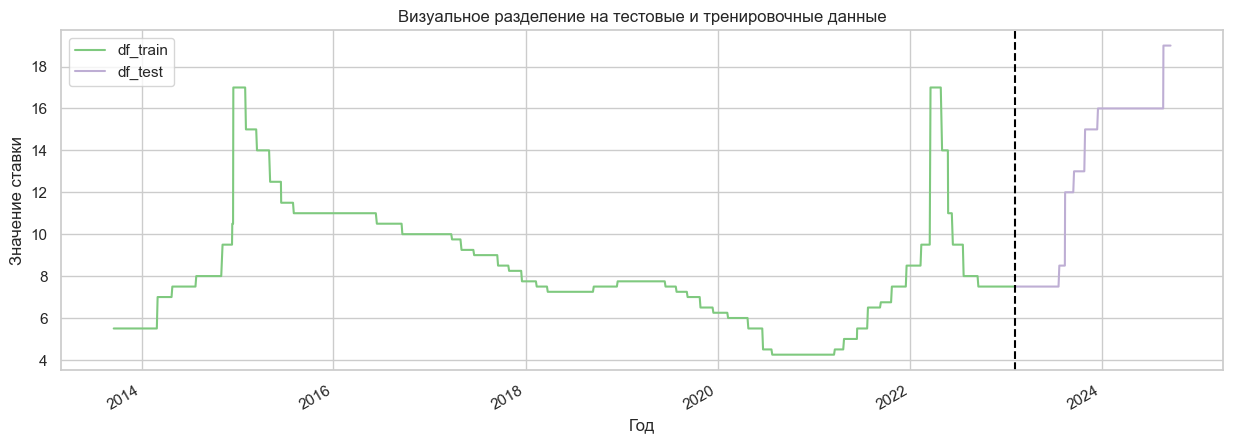

In [45]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [46]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*config['parcing']['pred_days'])

# Baseline Prophet on df_train для проверки модели

In [47]:
def train_model(df, **kwargs):
    """
    Обучение модели Prophet на данных.

    Аргументы:
        pandas.DataFrame: Данные для обучения с datetime и курсами.
        **kwargs: Параметры для модели Prophet.
    Возвращает: 
        Обученная модель.
    """
    model = Prophet(**kwargs)
    model.fit(df)
    return model

In [48]:
# Обучение модели на train
model_baseline = train_model(df_train)

00:13:40 - cmdstanpy - INFO - Chain [1] start processing
00:13:41 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
def generate_forecast(model, pred_days):
    """
    Генерирует прогноз на заданное количество дней вперед.

    Параметры:
    - model: модель, используемая для прогнозирования
    - pred_days: количество дней, на которое нужно сделать прогноз

    Возвращает:
    - forecast: DataFrame с прогнозом
    """
    future = model.make_future_dataframe(periods=pred_days, freq='D')
    forecast = model.predict(future)
    return forecast

In [50]:
# Создание df с прогнозом
forecast = generate_forecast(model_baseline, pred_days)

In [51]:
def plot_forecast(model, forecast):
    """
    Отображает график прогноза и компоненты модели.

    Параметры:
    model (модель): Модель, использованная для прогнозирования.
    forecast (прогноз): Прогноз, полученный с помощью модели.

    Возвращает:
    None
    """

    FIGSIZE = (15, 5)
    # Смотрим график прогноза
    fig, ax = plt.subplots(1, figsize=FIGSIZE)
    model.plot(forecast, ax=ax)
    plt.show()

    # Смотрим тренд, годовые и сезонные признаки
    fig, ax = plt.subplots(1, figsize=FIGSIZE)
    model.plot_components(forecast)
    plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


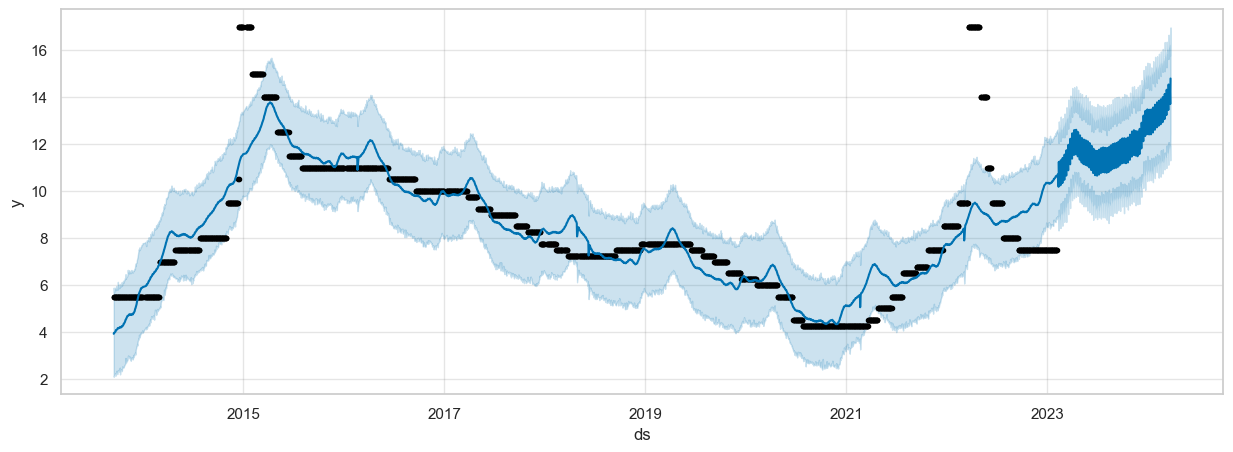

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

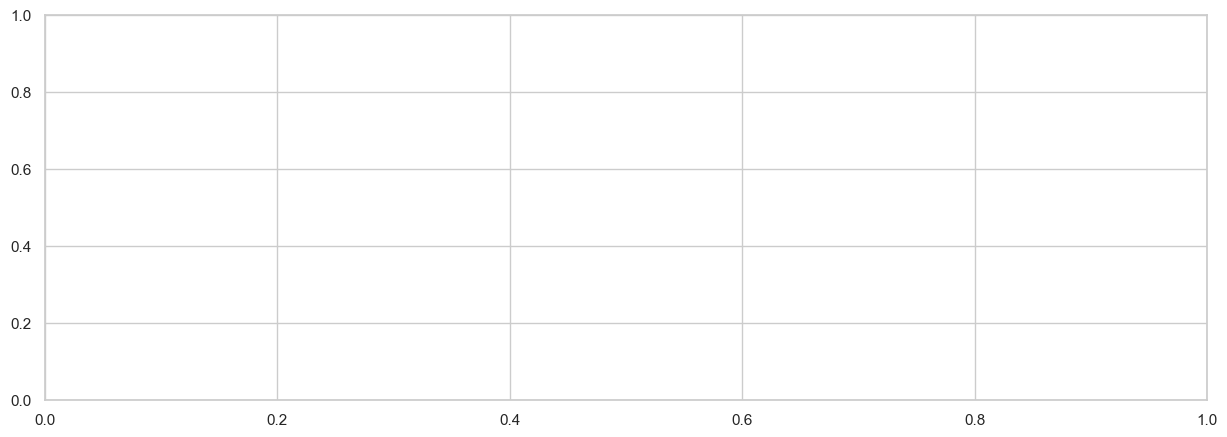

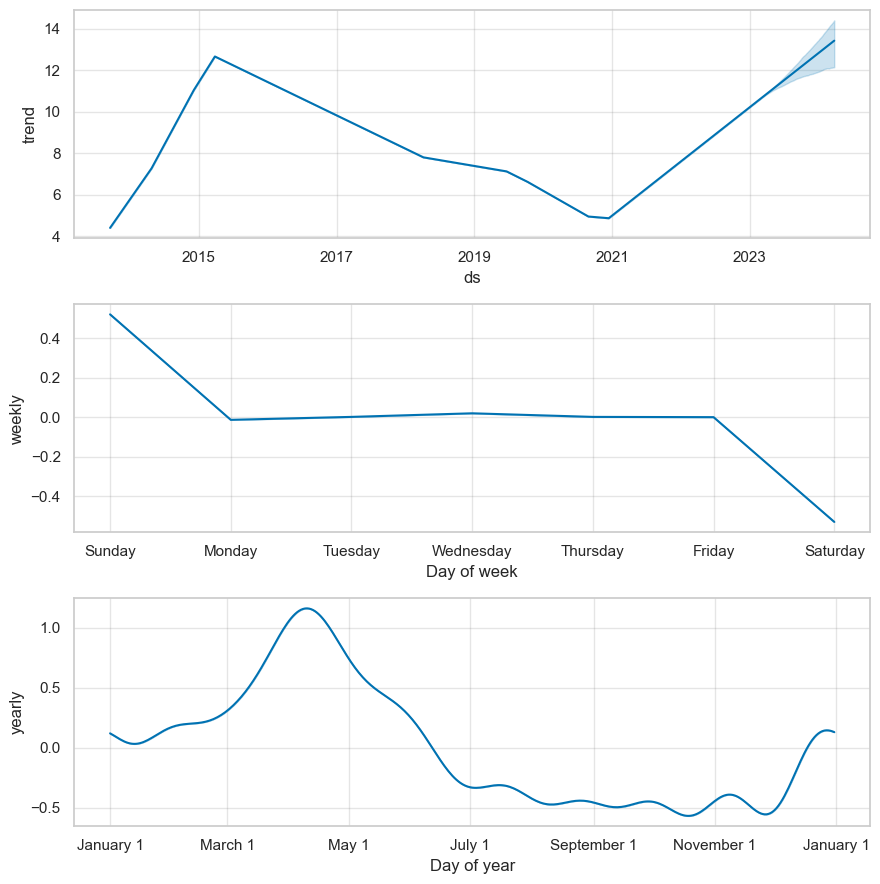

In [52]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки
plot_forecast(model_baseline, forecast)

## Сравнение фактов и прогнозов

In [53]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
407,2024-09-13,14.165927,11.446025,16.968059
408,2024-09-16,14.179333,11.437250,16.977820
409,2024-09-17,14.204754,11.432226,17.115329
410,2024-09-18,14.233923,11.383708,17.076241
411,2024-09-19,14.227218,11.407665,17.113990


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


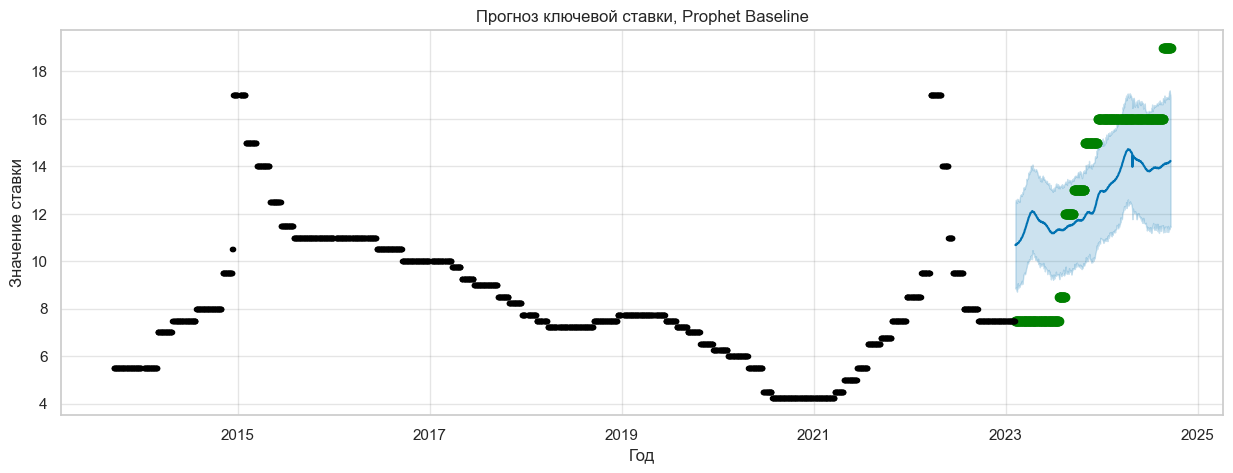

In [54]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

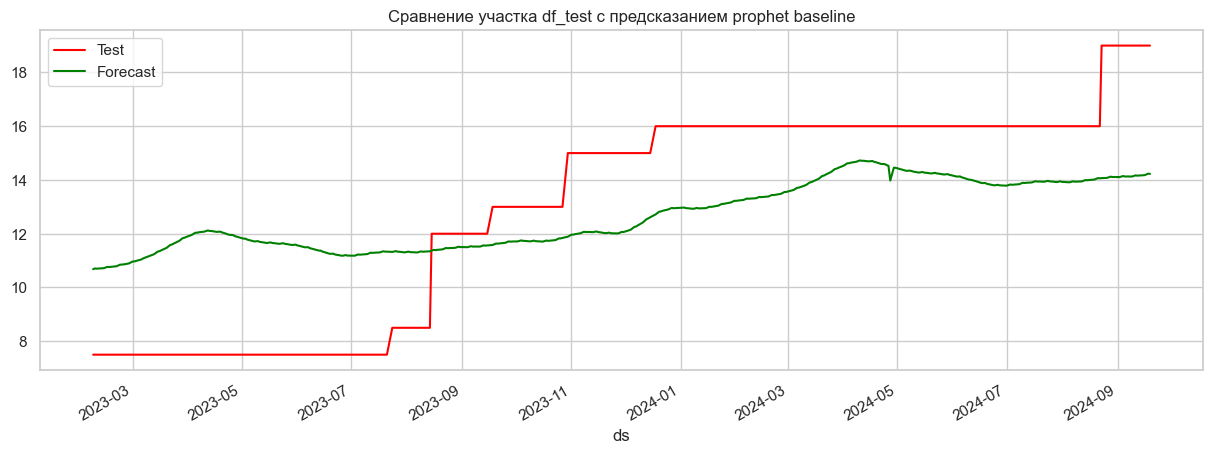

In [55]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [56]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.714647,0.253819,8.74254,2.956779


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [57]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

C:\Users\myxa-\AppData\Local\Temp\ipykernel_5072\3236026523.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


In [58]:
# Тренировка модели с праздниками
model_with_holidays = train_model(df_train, holidays=holiday)

00:13:45 - cmdstanpy - INFO - Chain [1] start processing
00:13:45 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
# Создание df с прогнозом
forecast = generate_forecast(model_with_holidays, pred_days)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


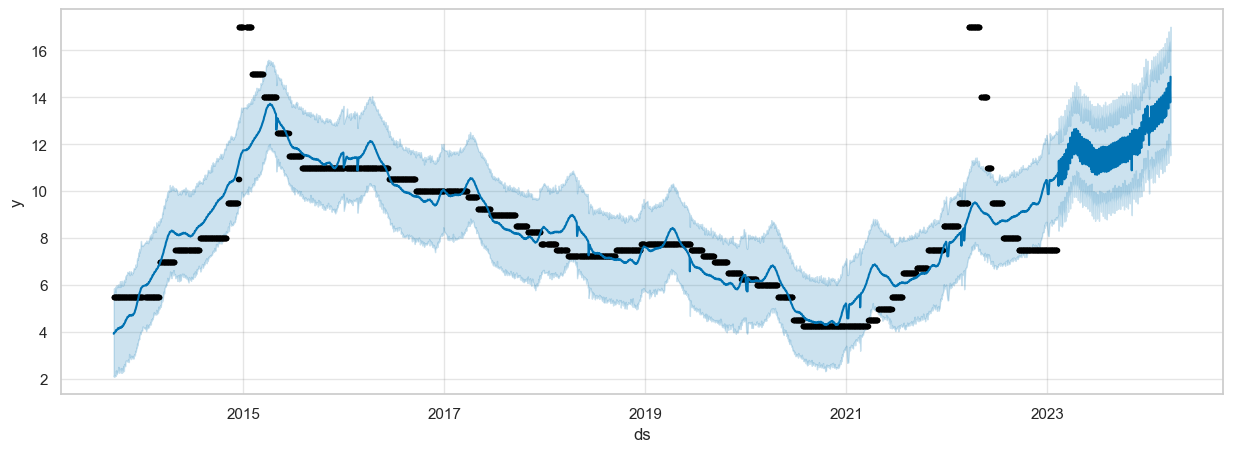

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

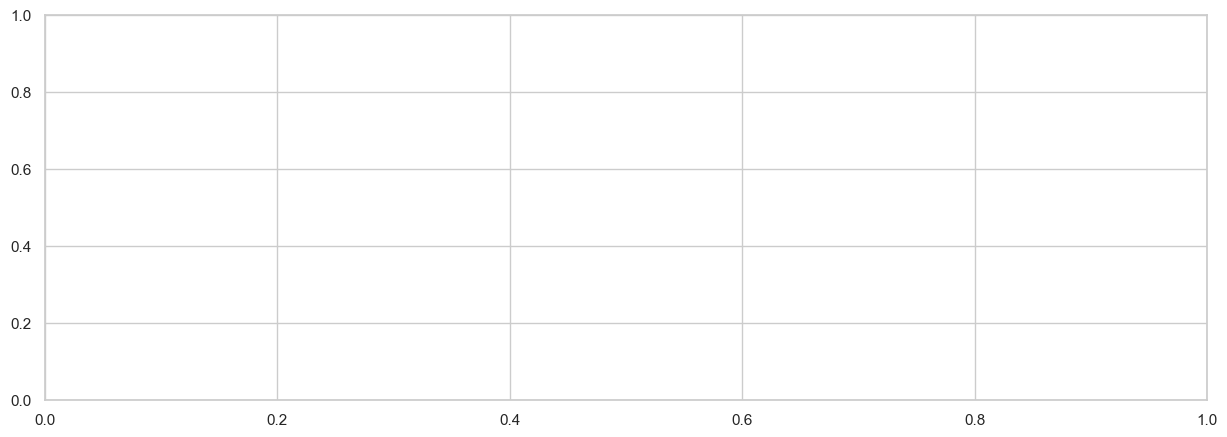

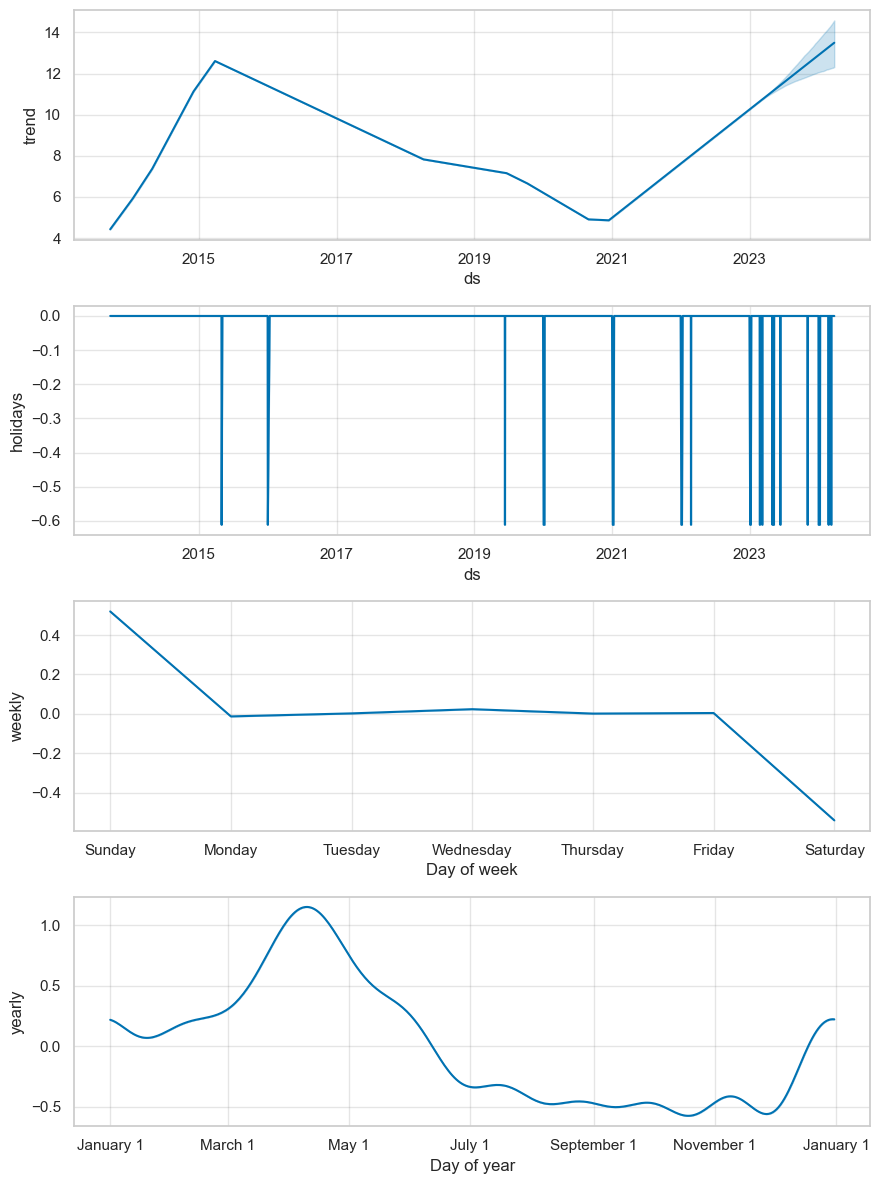

In [60]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки обученной модели с праздниками
plot_forecast(model_with_holidays, forecast)

## Сравнение фактов и прогнозов

In [61]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
407,2024-09-13,14.248511,11.704292,16.995268
408,2024-09-16,14.258008,11.551324,16.986960
409,2024-09-17,14.283294,11.518848,16.961320
410,2024-09-18,14.314983,11.459450,17.088522
411,2024-09-19,14.303440,11.674531,17.183468


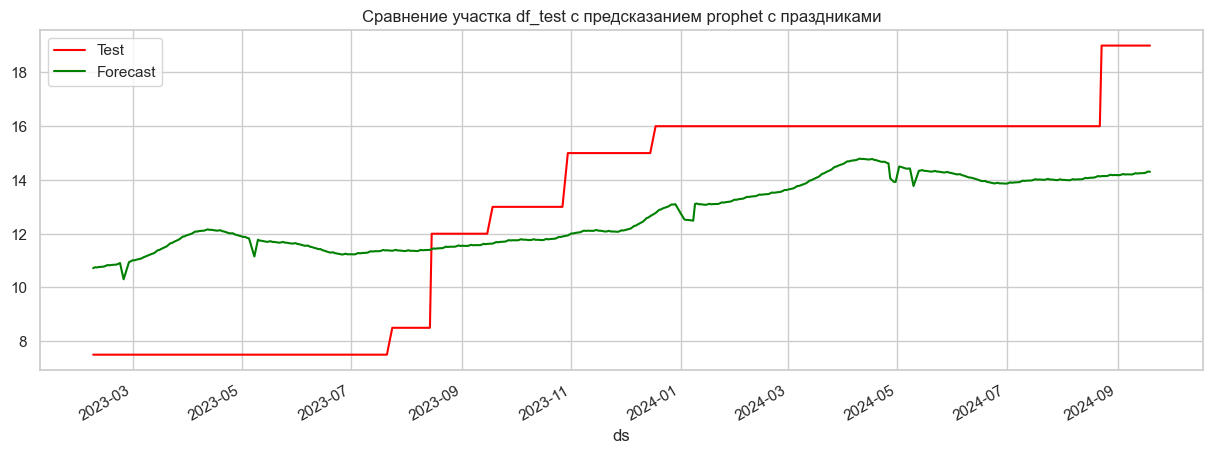

In [62]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [63]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.714647,0.253819,8.742540,2.956779
0,Prophet_with_holidays,2.689882,0.253073,8.680426,2.946256


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [64]:
def optimize_prophet_hyperparameters(df_train, model_path, params_path, **config):
    """
    Функция оптимизации гиперпараметров модели Prophet.

    Параметры:
    - df_train (pd.DataFrame): Данные для обучения модели.
    - model_path (str): Путь к директории, где будет сохранена лучшая модель.
    - params_path (str): Путь к директории, где будут сохранены лучшие параметры.
    - config (dict): Словарь с конфигурацией.

    Возвращает:
    - prophet_best_params (dict): Лучшие параметры модели Prophet.
    """

    # Определите целевую функцию для оптимизации
    def objective(trial):
        best_score = float('inf')
        # Гиперпараметры для настройки
        changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5)
        seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10)
        holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10)
        seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

        # Создайте модель Prophet с гиперпараметрами
        model = Prophet(changepoint_prior_scale=changepoint_prior_scale,
                        seasonality_prior_scale=seasonality_prior_scale,
                        holidays_prior_scale=holidays_prior_scale,
                        seasonality_mode=seasonality_mode,
                        )

        # Обучите модель
        model.fit(df_train)

        # Выполните кросс-валидацию
        cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')

        # Расчет MAE
        mae = np.mean(np.abs(cv_results['y'] - cv_results['yhat']))

        score = mae

        # Обновляем best_score только если MAE лучше
        if score < best_score:
            best_score = score

        return score

    # Проверьте, существует ли сохраненная модель и лучшие параметры
    best_model_file = os.path.join(model_path, 'prophet_best_model.json')
    best_params_file = os.path.join(params_path, 'prophet_best_params.json')
    prophet_best_params = None
    if os.path.exists(best_model_file) and os.path.exists(best_params_file):
        print('Модель и параметры уже сохранены.')
        with open(best_model_file, 'r') as f:
            prophet_best_model = json.load(f)
        with open(best_params_file, 'r') as f:
            prophet_best_params = json.load(f)
        print('Лучшие параметры:', prophet_best_params)
    else:
        print('Модель или параметры не сохранены, выполняем поиск гиперпараметров')
        # Выполните поиск гиперпараметров с помощью Optuna
        study = optuna.create_study(direction='minimize')
        best_score = float('-inf')
        logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
        study.optimize(objective, n_trials=config['train']['N_TRIALS'], timeout=config['train']['TIMEOUT'])
        prophet_best_params = study.best_params
        # Сохраните модель и лучшие параметры
        with open(best_model_file, 'w') as f:
            json.dump(prophet_best_params, f, indent=4)
        with open(best_params_file, 'w') as f:
            json.dump(study.best_params, f, indent=4)
        print('Модель и параметры сохранены')
        print('Лучшие параметры:', study.best_params)

    return prophet_best_params

In [65]:
# Обучение модели на лучших параметрах
prophet_best_params = optimize_prophet_hyperparameters(df_train, model_path, params_path, config)

Модель и параметры уже сохранены.
Лучшие параметры: {'changepoint_prior_scale': 0.1580880521819518, 'seasonality_prior_scale': 4.808159785723873, 'holidays_prior_scale': 4.224231434775671, 'seasonality_mode': 'additive'}


## Лучшие параметры после обучения по сетке

In [66]:
# Обучение модели на лучших параметрах
final_test_model = train_model(df_train, **prophet_best_params)

00:13:49 - cmdstanpy - INFO - Chain [1] start processing
00:13:49 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
# Создание df с прогнозом
forecast = generate_forecast(final_test_model, pred_days)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


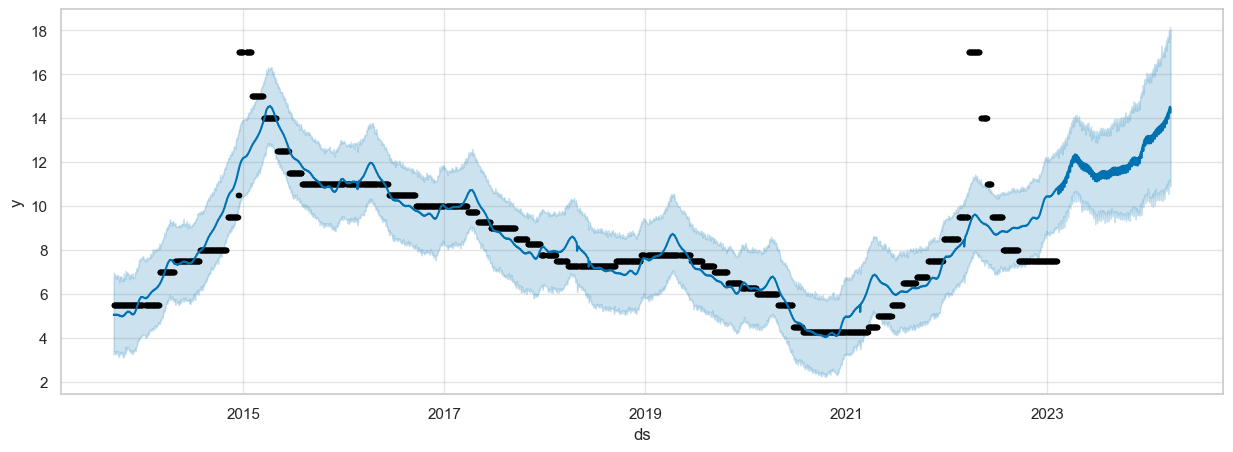

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

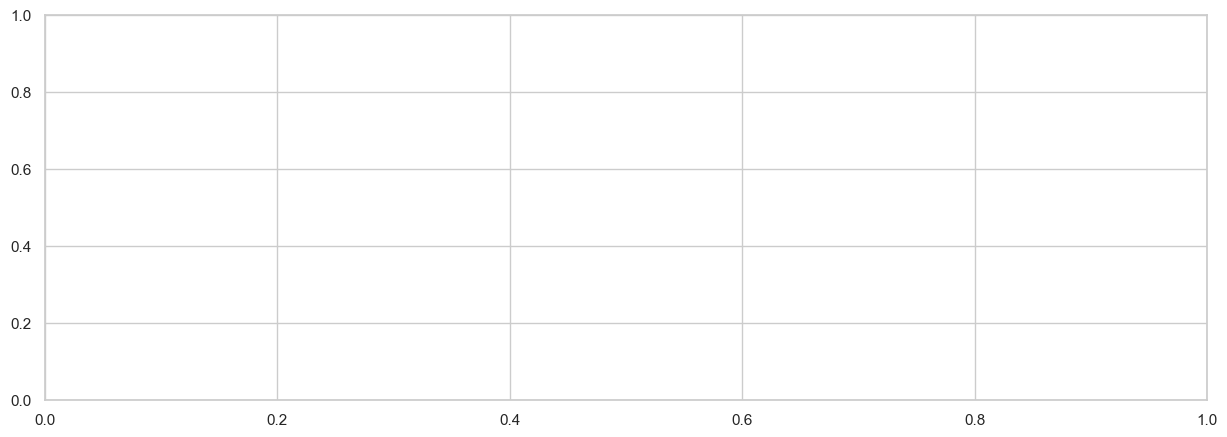

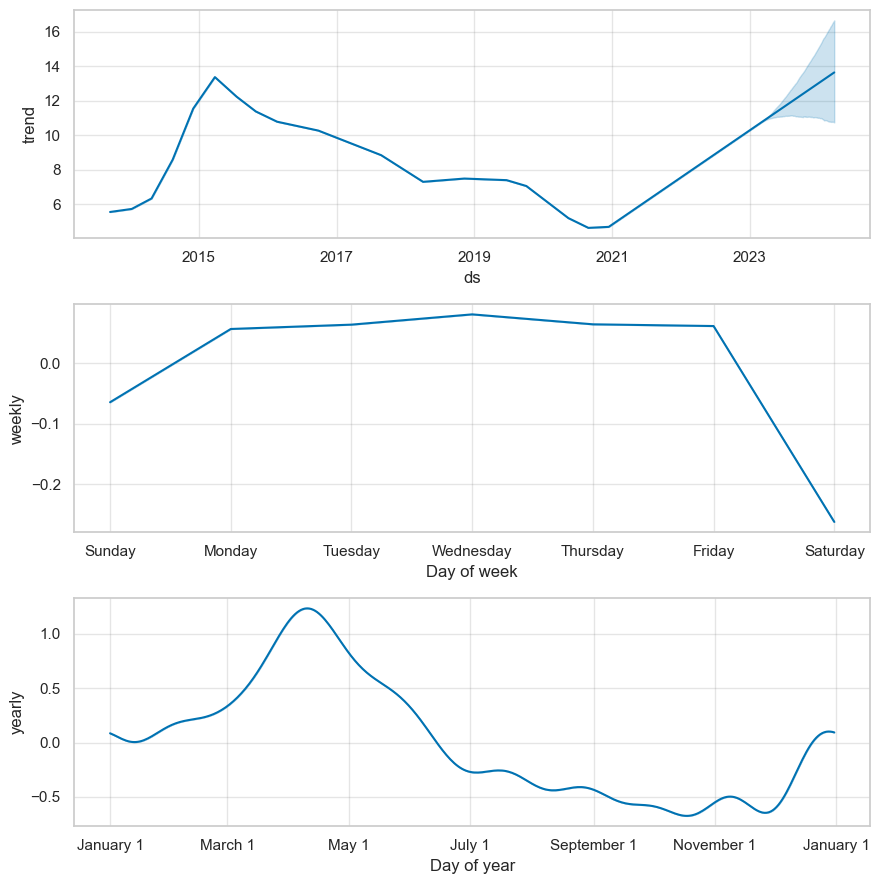

In [68]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки после обучния на лучших параметрах
plot_forecast(final_test_model, forecast)

## Сравнение фактов и прогнозов

In [69]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
407,2024-09-13,14.466893,8.888010,19.593289
408,2024-09-16,14.467486,8.682828,19.795127
409,2024-09-17,14.478048,9.183644,19.533492
410,2024-09-18,14.499140,8.754925,19.790483
411,2024-09-19,14.487482,8.786515,19.710369


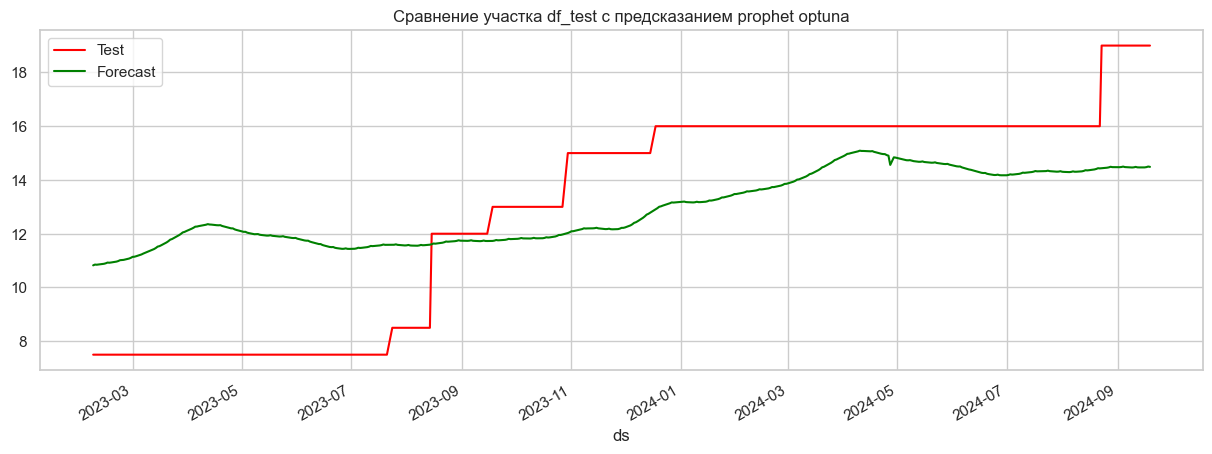

In [70]:
# Сравнение участка df_test с предсказанием prophet optuna
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet optuna')
plt.show()

In [71]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_best_params_optuna')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.714647,0.253819,8.742540,2.956779
0,Prophet_with_holidays,2.689882,0.253073,8.680426,2.946256
0,Prophet_best_params_optuna,2.597248,0.251196,8.530880,2.920767


In [72]:
# # Сохранение метрик
# with open(metrics_path, 'w') as f:
#     json.dump(metrics, f)

In [73]:
# Добавляем столбец в metrics с текущей датой и временем
metrics['date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [74]:
# Сохранение метрик
metrics.to_json(metrics_path, orient='records', lines=True, mode='a')

# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на полных данных с пронозированием на будущий период

# Prophet baseline on df

In [75]:
# Обучение модели на df
prophet_bl = train_model(df)

00:13:52 - cmdstanpy - INFO - Chain [1] start processing
00:13:53 - cmdstanpy - INFO - Chain [1] done processing


In [76]:
# Создание df с прогнозом
forecast_bl = generate_forecast(prophet_bl, pred_days_forecast)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


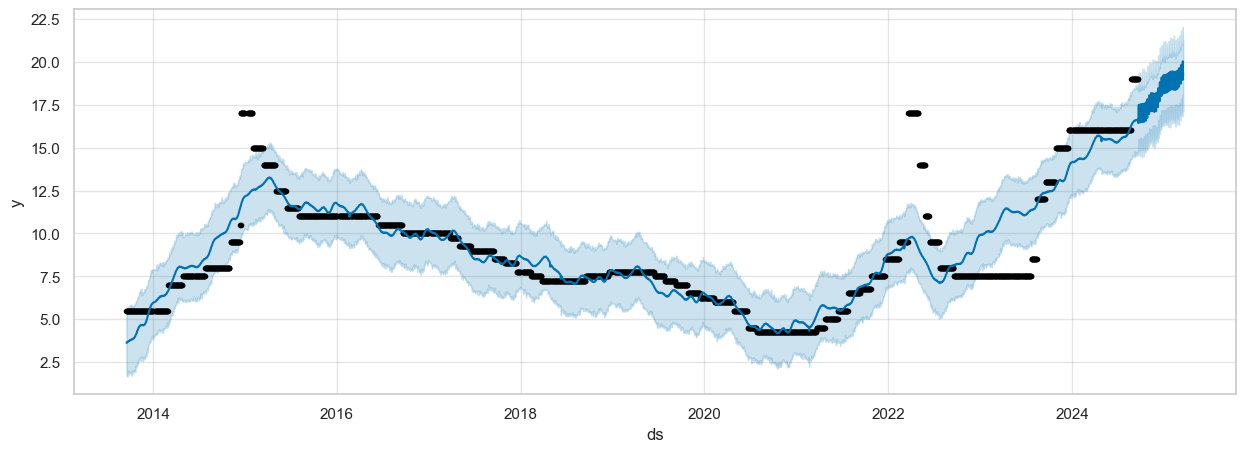

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

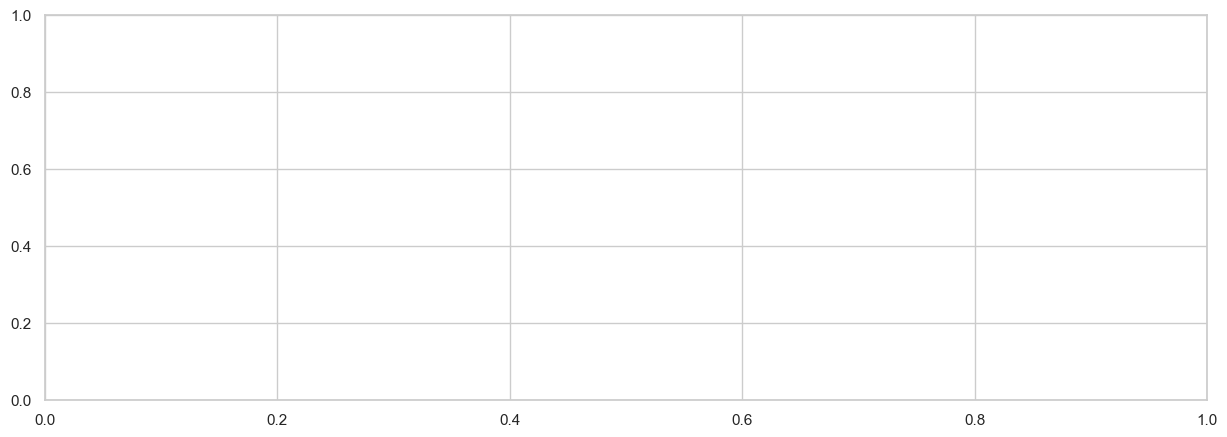

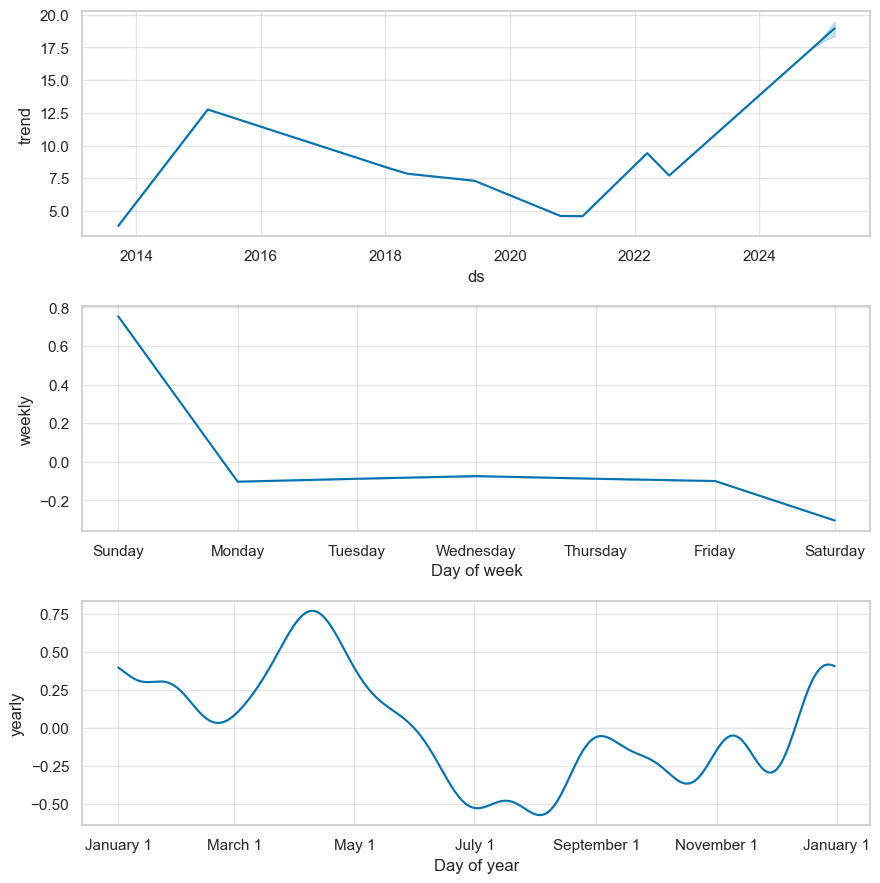

In [77]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки после обучния на лучших параметрах
plot_forecast(prophet_bl, forecast_bl)

# Prophet best params on df

In [78]:
# Обучение модели с лучшими параметрами на df
final_test_model = train_model(df, **prophet_best_params)

00:13:55 - cmdstanpy - INFO - Chain [1] start processing
00:13:58 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
# Создание df с прогнозом
forecast_ftm = generate_forecast(final_test_model, pred_days_forecast)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


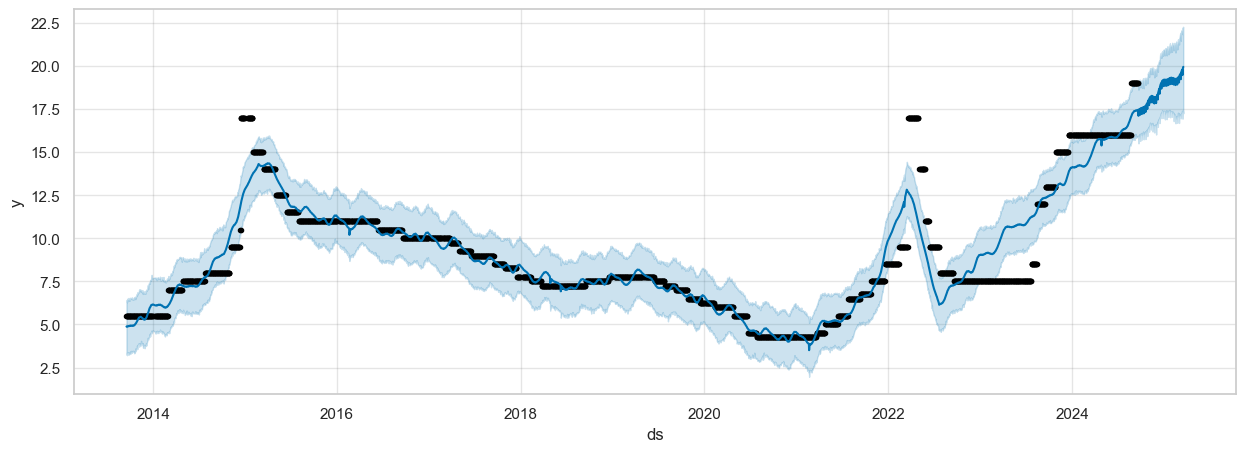

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

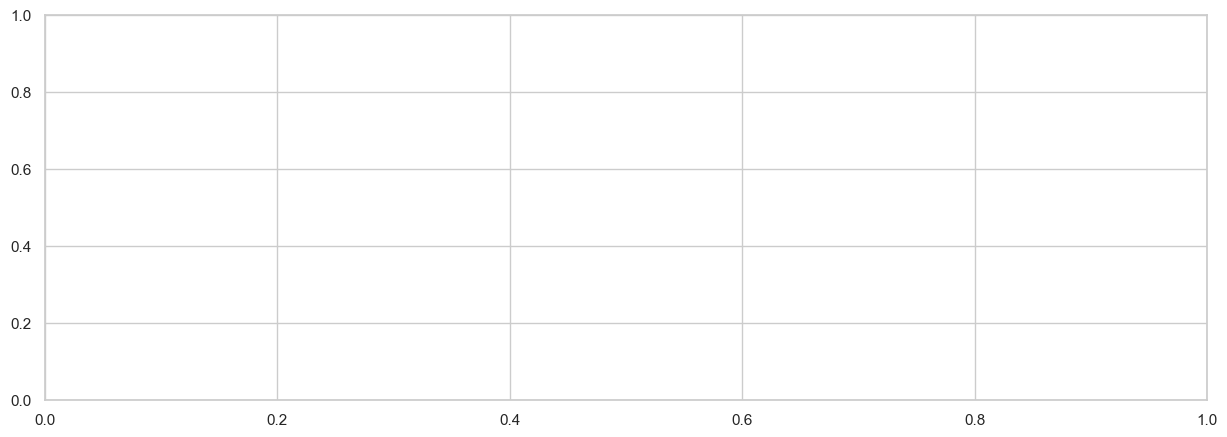

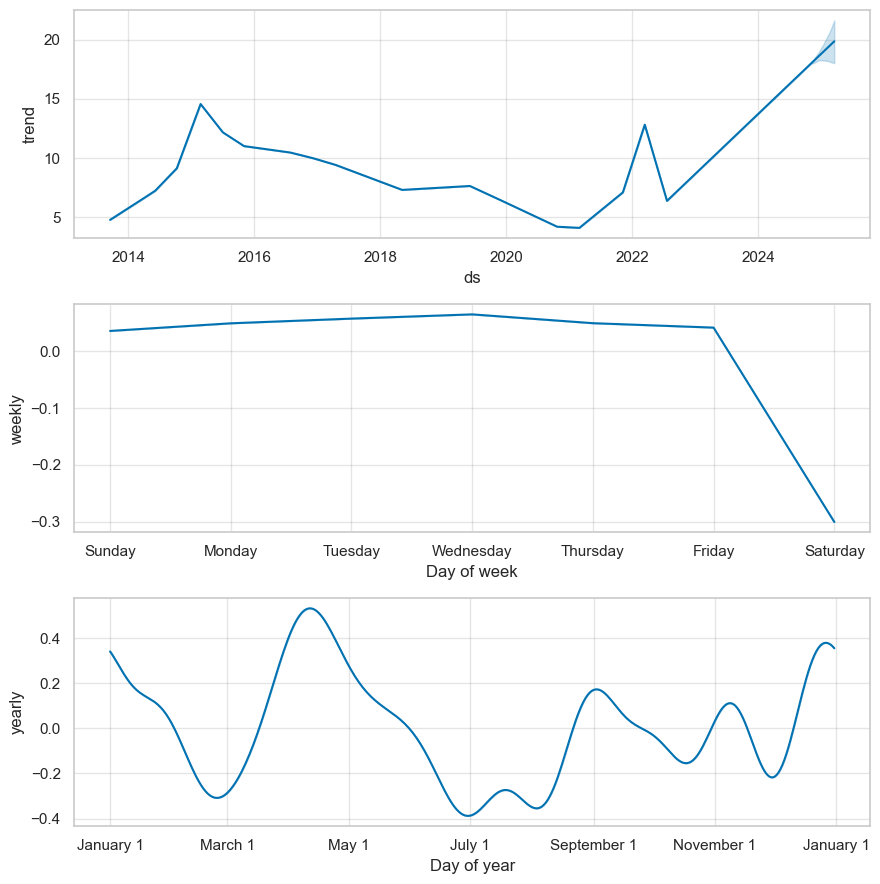

In [80]:
# Смотрим график прогноза, тренд, годовые и сезонные признаки после обучния на лучших параметрах
plot_forecast(final_test_model, forecast_ftm)

# Сравнение прогнозов обученных моделей

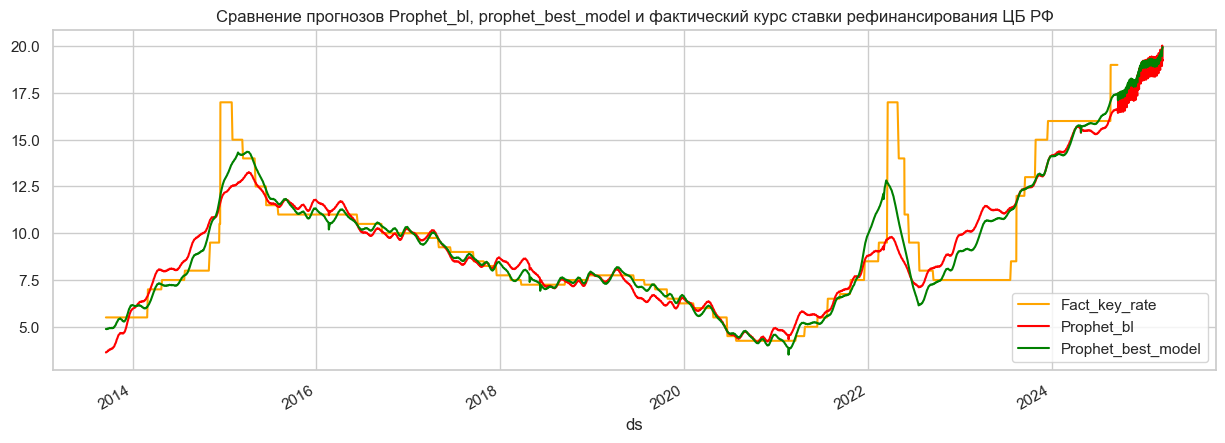

In [81]:
# Сравнение прогнозов Prophet_bl, prophet_best_model и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_model', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, prophet_best_model и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

In [82]:
# Вычисление последней даты в df
last_date = df['ds'].max()

# Создание df с курсами ставки рефинансирования, фактический курс, прогноз бейзлайна, прогноз с лучшими параметрами
key_rate = pd.DataFrame({
    'date': [last_date],
    'fact': [df.loc[df['ds'] == last_date, 'y'].iloc[0]],
    'baseline': [forecast_bl.loc[forecast_bl['ds'] == last_date, 'yhat'].iloc[0]],
    'best_params': [forecast_ftm.loc[forecast_ftm['ds'] == last_date, 'yhat'].iloc[0]]
})

# Отображение df
key_rate

,date,fact,baseline,best_params
0,2024-09-19,19.0,16.634799,17.445476
